In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import path
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the CSV and generate additional features

In [ ]:
def Generate_new_feature_in_csv(input=None):
    '''Generate new feature, Mapping the output feature'''
    if input is None:
        input = "/content/drive/MyDrive/MajorProject/train.csv"
    data = pd.read_csv(input)
    Defect_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}
    diagnosis_all_dict = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
    data['binary_type'] = data['diagnosis'].map(Defect_binary.get)
    data['type'] = data['diagnosis'].map(diagnosis_all_dict.get)
    return data

# Call the function
Generate_new_feature_in_csv()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR
...,...,...,...,...
3657,ffa47f6a7bf4,2,DR,Moderate
3658,ffc04fed30e6,0,No_DR,No_DR
3659,ffcf7b45f213,2,DR,Moderate
3660,ffd97f8cd5aa,0,No_DR,No_DR


# Split the data

In [ ]:
def data_separation():
    data = Generate_new_feature_in_csv()
    train, val = train_test_split(data, test_size=0.2, stratify=data['type'])
    train, test = train_test_split(train, test_size=0.15 / (1 - 0.15), stratify=train['type'])
    return train, val, test

# Separate the images into respective directories

In [ ]:
import os
import shutil

def mkdir_separate_image():
    train, val, test = data_separation()  # Assume data_separation() returns train, val, test dataframes

    base_dir = '/content/drive/MyDrive/ImageDirectories'  # Define your base directory path here
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    # Create train, val, test directories if they do not exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    src_dir = '/content/drive/MyDrive/6thSem Minor Project/gaussian_filtered_images'

    # Helper function to copy files based on dataset type
    def copy_files(data, dest_dir):
        for index, row in data.iterrows():
            diagnosis = row['type']
            binary_diagnosis = row['binary_type']
            id_code = row['id_code'] + ".png"
            srcfile = os.path.join(src_dir, diagnosis, id_code)
            dst_dir = os.path.join(dest_dir, binary_diagnosis)
            os.makedirs(dst_dir, exist_ok=True)
            shutil.copy(srcfile, dst_dir)

    # Copy files to train, val, and test directories
    copy_files(train, train_dir)
    copy_files(val, val_dir)
    copy_files(test, test_dir)

mkdir_separate_image()

# Load images using ImageDataGenerator


In [ ]:
# Load images using ImageDataGenerator
def ImageDataGenerator_Data():
    train_dir = '/content/drive/MyDrive/MajorProject/ImageDirectories/train'
    val_dir = '/content/drive/MyDrive/MajorProject/ImageDirectories/val'
    test_dir = '/content/drive/MyDrive/MajorProject/ImageDirectories/test'

    train_batches = ImageDataGenerator(rescale=1/255.).flow_from_directory(train_dir, target_size=(224,224), shuffle=True)
    val_batches = ImageDataGenerator(rescale=1/255.).flow_from_directory(val_dir, target_size=(224,224), shuffle=True)
    test_batches = ImageDataGenerator(rescale=1/255.).flow_from_directory(test_dir, target_size=(224,224), shuffle=True)

    return train_batches, val_batches, test_batches

# Initialize train, validation, and test batches
train_batches, val_batches, test_batches = ImageDataGenerator_Data()


Found 2412 images belonging to 2 classes.
Found 733 images belonging to 2 classes.
Found 517 images belonging to 2 classes.


#CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define CNN model
def CNN_Model():
    model = tf.keras.Sequential([
        # Data augmentation layers
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),

        layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(2, activation='softmax')  # softmax for multi-class
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train CNN model with augmented data
cnn_model = CNN_Model()

# Include early stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Add data augmentation to the training and validation batches (use ImageDataGenerator)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Assuming you have a directory or data generator for training and validation
# Use 'categorical' for multi-class classification (one-hot encoded labels)
train_batches = train_datagen.flow_from_directory('/content/train', target_size=(224, 224), batch_size=32, class_mode='categorical')
val_batches = val_datagen.flow_from_directory('/content/val', target_size=(224, 224), batch_size=32, class_mode='categorical')

# Train the model
history = cnn_model.fit(train_batches, validation_data=val_batches, epochs=10, callbacks=[es])

# Evaluate CNN model
cnn_loss, cnn_acc = cnn_model.evaluate(val_batches)
print(f"CNN Test Accuracy: {cnn_acc:.4f}, Loss: {cnn_loss:.4f}")

# Save model
cnn_model.save('final_model.keras')


Found 2412 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.7919 - loss: 0.5223 - val_accuracy: 0.5075 - val_loss: 1.6831
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8564 - loss: 0.3652 - val_accuracy: 0.5075 - val_loss: 2.2615
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8653 - loss: 0.3336 - val_accuracy: 0.5075 - val_loss: 2.8126
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.5274 - loss: 2.7041
CNN Test Accuracy: 0.5075, Loss: 2.8126


# Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# Define the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_batches = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ImageDirectories/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_batches = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ImageDirectories/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta=0.01,
    restore_best_weights=True
)

# Train the model for a maximum of 10 epochs
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=10,  # Restrict to 10 epochs
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_batches)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

# Save the trained model in the desired directory
model.save('/content/drive/MyDrive/TrainedModels/transfer_learning_model.keras')

Found 2412 images belonging to 2 classes.
Found 733 images belonging to 2 classes.
Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 593ms/step - accuracy: 0.6979 - loss: 0.6176 - val_accuracy: 0.8799 - val_loss: 0.3020
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 511ms/step - accuracy: 0.9055 - loss: 0.2757 - val_accuracy: 0.9059 - val_loss: 0.2665
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 82s 533ms/step - accuracy: 0.9264 - loss: 0.2162 - val_accuracy: 0.9250 - val_loss: 0.2162
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 514ms/step - accuracy: 0.9302 - loss: 0.2231 - val_accuracy: 0.9332 - val_loss: 0.2137
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 510ms/step - accuracy: 0.9441 - loss: 0.1943 - val_accuracy: 0.9277 - val_loss: 0.2140
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9315 - loss: 0.1987
Validation Accuracy: 0.9250, Loss: 0.2162


# Transfer Learning Classification Report

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Preprocess images for MobileNetV2
def preprocess_images(images):
    # Resize to 224x224 and normalize pixel values
    images_resized = tf.image.resize(images, [224, 224])
    return images_resized / 255.0  # Scale to [0, 1] as required by MobileNetV2

# Load test data (assuming directories for images)
# Replace these paths with your actual test dataset directories
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_batches = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/ImageDirectories/test',  # Path to the test dataset
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the fine-tuned transfer learning model
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/TrainedModels/transfer_learning_model.keras')

# Evaluate the model
cnn_loss, cnn_acc = cnn_model.evaluate(test_batches, verbose=1)
print(f"Transfer Learning Model Test Accuracy: {cnn_acc:.4f}, Loss: {cnn_loss:.4f}")

# Predict and generate classification report
y_pred_cnn_probs = cnn_model.predict(test_batches)
y_pred_cnn = y_pred_cnn_probs.argmax(axis=1)

# Get true labels from test_batches
y_test = test_batches.classes  # Ground-truth labels
class_labels = list(test_batches.class_indices.keys())  # Class label names

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_cnn, target_names=class_labels))

Found 517 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 285s 16s/step - accuracy: 0.9307 - loss: 0.2281
Transfer Learning Model Test Accuracy: 0.9168, Loss: 0.2427
17/17 ━━━━━━━━━━━━━━━━━━━━ 308s 18s/step
Classification Report:
               precision    recall  f1-score   support

          DR       0.91      0.92      0.92       262
       No_DR       0.92      0.91      0.92       255

    accuracy                           0.92       517
   macro avg       0.92      0.92      0.92       517
weighted avg       0.92      0.92      0.92       517



#Upload Image to Test the Trained CNN Model

Saving No_DR1.png to No_DR1.png


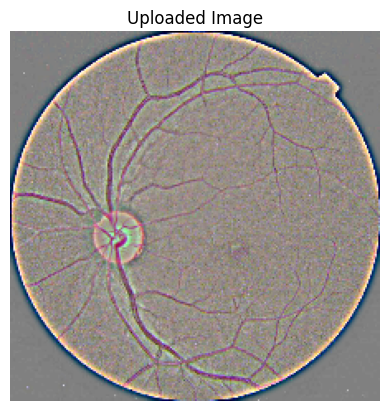

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: No DR (No Diabetic Retinopathy)


In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt

# Function to upload image and predict using the transfer learning model
def upload_and_predict():
    # Upload image file
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Load the image
        img = cv2.imread(fn)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (224, 224))
        plt.imshow(img_rgb)
        plt.title("Uploaded Image")
        plt.axis('off')
        plt.show()

        # Preprocess the image for MobileNetV2
        img_array = np.array(img_resized) / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Load the saved transfer learning model
        model = tf.keras.models.load_model('transfer_learning_model.keras')

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)

        # Define class labels (adjust if you have different labels)
        class_labels = ['DR (Diabetic Retinopathy)', 'No DR (No Diabetic Retinopathy)']

        # Output the result
        print(f"Prediction: {class_labels[predicted_class]}")

# Test the model with an uploaded image
upload_and_predict()

#Random Forest and SVM Model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import joblib

# Resize images and preprocess dataset
def preprocess_dataset(generator, target_size=(32, 32), flatten=False):
    all_images = []
    all_labels = []
    for images, labels in generator:
        # Resize all images in the batch
        images_resized = tf.image.resize(images, target_size).numpy()
        if flatten:
            # Flatten images for traditional ML models
            images_resized = images_resized.reshape(images_resized.shape[0], -1)
        all_images.append(images_resized)
        all_labels.append(labels)
    # Concatenate all preprocessed images and labels
    return np.vstack(all_images), np.vstack(all_labels)

# Ensure labels are in 1D format by extracting class indices if needed
def ensure_1d_labels(labels):
    if labels.ndim > 1:
        return np.argmax(labels, axis=1)
    return labels

# Preprocess test data
target_size = (32, 32)
flatten = True

print("Preprocessing test data...")
preprocessed_images, test_labels = preprocess_dataset(test_batches, target_size=target_size, flatten=flatten)

# Scale the image data
print("Scaling test data...")
scaler = joblib.load('/content/drive/MyDrive/MajorProject/TrainedModels/scaler.pkl')  # Load pre-fitted scaler
preprocessed_images = scaler.transform(preprocessed_images.astype('float32'))

# Convert test labels to 1D
test_labels = ensure_1d_labels(test_labels)

# Batch prediction function
def predict_with_model(images, model):
    return model.predict(images)

# Predict with Random Forest
print("Loading Random Forest model...")
rf_model = joblib.load('/content/drive/MyDrive/MajorProject/TrainedModels/random_forest_model.pkl')
print("Predicting with Random Forest...")
rf_predictions = predict_with_model(preprocessed_images, rf_model)
rf_predictions = ensure_1d_labels(rf_predictions)
print("Random Forest Classification Report:\n", classification_report(test_labels, rf_predictions))

# Predict with SVM
print("Loading SVM model...")
svm_model = joblib.load('/content/drive/MyDrive/MajorProject/TrainedModels/svm_model.pkl')
print("Predicting with SVM...")
svm_predictions = predict_with_model(preprocessed_images, svm_model)
svm_predictions = ensure_1d_labels(svm_predictions)
print("SVM Classification Report:\n", classification_report(test_labels, svm_predictions))


Random Forest Validation Accuracy: 0.9150
Random Forest Test Accuracy: 0.9150
SVM (SGD) Validation Accuracy: 0.9100
SVM (SGD) Test Accuracy: 0.9150


81

# Random Forest & SVM Classification Report

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import joblib

# Resize images and preprocess dataset
def preprocess_dataset(generator, target_size=(32, 32), flatten=False):
    all_images = []
    all_labels = []
    for images, labels in generator:
        # Resize all images in the batch
        images_resized = tf.image.resize(images, target_size).numpy()
        if flatten:
            # Flatten images for traditional ML models
            images_resized = images_resized.reshape(images_resized.shape[0], -1)
        all_images.append(images_resized)
        all_labels.append(labels)
    # Concatenate all preprocessed images and labels
    return np.vstack(all_images), np.vstack(all_labels)

# Ensure labels are in 1D format by extracting class indices if needed
def ensure_1d_labels(labels):
    if labels.ndim > 1:
        return np.argmax(labels, axis=1)
    return labels

# Preprocess test data
target_size = (32, 32)
flatten = True

print("Preprocessing test data...")
preprocessed_images, test_labels = preprocess_dataset(test_batches, target_size=target_size, flatten=flatten)

# Scale the image data
print("Scaling test data...")
scaler = joblib.load('/content/drive/MyDrive/MajorProject/TrainedModels/scaler.pkl')  # Load pre-fitted scaler
preprocessed_images = scaler.transform(preprocessed_images.astype('float32'))

# Convert test labels to 1D
test_labels = ensure_1d_labels(test_labels)

# Batch prediction function
def predict_with_model(images, model):
    return model.predict(images)

# Predict with Random Forest
print("Loading Random Forest model...")
rf_model = joblib.load('/content/drive/MyDrive/MajorProject/TrainedModels/random_forest_model.pkl')
print("Predicting with Random Forest...")
rf_predictions = predict_with_model(preprocessed_images, rf_model)
rf_predictions = ensure_1d_labels(rf_predictions)
print("Random Forest Classification Report:\n", classification_report(test_labels, rf_predictions))

# Predict with SVM
print("Loading SVM model...")
svm_model = joblib.load('/content/drive/MyDrive/MajorProject/TrainedModels/svm_model.pkl')
print("Predicting with SVM...")
svm_predictions = predict_with_model(preprocessed_images, svm_model)
svm_predictions = ensure_1d_labels(svm_predictions)
print("SVM Classification Report:\n", classification_report(test_labels, svm_predictions))


Preprocessing test data...


KeyboardInterrupt: 

In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from openpyxl import Workbook
import cv2


#XG-Boost

In [ ]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Define the base directory where the images are stored
base_dir = '/content/drive/MyDrive/6thSem Minor Project/gaussian_filtered_images/'

# Load and preprocess the CSV to define 'data'
csv_path = '/content/drive/MyDrive/6thSem Minor Project/train.csv'  # Update if needed
data = Generate_new_feature_in_csv(input=csv_path)

# Verify that 'id_code' exists in the loaded data
if 'id_code' not in data.columns:
    raise KeyError("The 'id_code' column is missing in the dataset. Check the input CSV.")

# Collect all image file paths from subdirectories
all_image_paths = glob.glob(os.path.join(base_dir, '*', '*'))  # Recursively find all image files
print(f"Total images found: {len(all_image_paths)}")

# Create a dictionary mapping image filenames (without extensions) to full paths
image_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in all_image_paths
}

# Map 'id_code' to actual image paths
def map_id_to_path(id_code):
    return image_path_dict.get(id_code, None)

data['image_path'] = data['id_code'].apply(map_id_to_path)

# Filter out rows where the image is missing
data_with_images = data.dropna(subset=['image_path'])
print(f"Images matched with dataset: {len(data_with_images)}")

if data_with_images.empty:
    raise ValueError("No images matched with the dataset. Ensure filenames and paths are correct.")

# Preprocess images
def preprocess_images(image_paths):
    images = []
    missing_count = 0
    for path in image_paths:
        img = cv2.imread(path)  # Read the image
        if img is None:  # Handle missing or unreadable images
            print(f"Image at path {path} could not be read!")
            missing_count += 1
            continue
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        images.append(img)
    print(f"Successfully processed {len(images)} images. Missing images: {missing_count}")
    return np.array(images)

# Preprocess the images
X_preprocessed = preprocess_images(data_with_images['image_path'].tolist())

# Proceed with the rest of the pipeline
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_with_images['binary_type'])

# Ensure labels and features are consistent in size
if len(X_preprocessed) != len(y_encoded):
    raise ValueError("Mismatch between the number of images and labels!")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y_encoded, test_size=0.3, random_state=42
)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Data preprocessing and splitting complete.")

Total images found: 3662
Images matched with dataset: 3662
Successfully processed 3662 images. Missing images: 0
Data preprocessing and splitting complete.


In [ ]:
# Flatten the image data for XGBoost
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # Flatten to 2D

# Train and evaluate XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_flat, y_train)
y_pred_xgb = xgb_model.predict(X_test_flat)

# Generate classification report
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:54:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       559
           1       0.93      0.95      0.94       540

    accuracy                           0.94      1099
   macro avg       0.94      0.94      0.94      1099
weighted avg       0.94      0.94      0.94      1099



#Consolidated Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from google.colab import files

# Ensure y_test is in 1D class-label format
if len(test_batches.labels.shape) > 1:
    y_test = np.argmax(test_batches.labels, axis=1)
else:
    y_test = test_batches.labels

# Define y_pred_xgb placeholder if XGBoost predictions are not available
y_pred_xgb = [0] * len(y_test)  # Replace with actual predictions if using XGBoost

# Slice predictions to match y_test length
y_pred_cnn = np.argmax(cnn_model.predict(test_batches), axis=1)[:len(y_test)]
y_pred_rf = y_pred_rf[:len(y_test)]
y_pred_svm = y_pred_svm[:len(y_test)]
y_pred_xgb = y_pred_xgb[:len(y_test)]

# Collect metrics
models = ['CNN', 'SVM', 'Random Forest', 'XGBoost']
predictions = [y_pred_cnn, y_pred_svm, y_pred_rf, y_pred_xgb]

metrics = {
    'Model': models,
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for model_name, y_pred in zip(models, predictions):
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics['Accuracy'].append(acc)
    metrics['Precision'].append(report['weighted avg']['precision'])
    metrics['Recall'].append(report['weighted avg']['recall'])
    metrics['F1 Score'].append(report['weighted avg']['f1-score'])

# Save to Excel
results_df = pd.DataFrame(metrics)
file_name = '/content/drive/MyDrive/TrainedModels/model_comparison_results_corrected.xlsx'
results_df.to_excel(file_name, index=False)
print(f"Results saved to {file_name}")

# Optionally download the file if in Google Colab
files.download('/content/drive/MyDrive/TrainedModels/model_comparison_results_corrected.xlsx')

23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 580ms/step
Results saved to model_comparison_results_corrected.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>